In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

In [3]:
train_df.sample(15)

,id,date,store_nbr,family,sales,onpromotion
2330277,2330277,2016-08-03,42,HOME AND KITCHEN I,5.000,0
1485247,1485247,2015-04-16,32,HOME AND KITCHEN II,2.000,0
2602418,2602418,2017-01-04,29,BREAD/BAKERY,522.000,7
1557107,1557107,2015-05-26,49,BEAUTY,11.000,0
2013988,2013988,2016-02-08,18,SCHOOL AND OFFICE SUPPLIES,1.000,0
52515,52515,2013-01-30,32,GROCERY I,875.000,0
1733940,1733940,2015-09-03,10,LINGERIE,1.000,0
306373,306373,2013-06-21,6,BABY CARE,0.000,0
2964181,2964181,2017-07-26,29,"LIQUOR,WINE,BEER",59.000,1
1101151,1101151,2014-09-11,6,CLEANING,792.000,1


In [4]:
test_df.sample(15)

,id,date,store_nbr,family,onpromotion
1716,3002604,2017-08-16,8,AUTOMOTIVE,0
2347,3003235,2017-08-17,25,BOOKS,0
12210,3013098,2017-08-22,51,AUTOMOTIVE,0
12814,3013702,2017-08-23,19,EGGS,1
13140,3014028,2017-08-23,28,CELEBRATION,0
25835,3026723,2017-08-30,33,PREPARED FOODS,0
24016,3024904,2017-08-29,32,PERSONAL CARE,5
21530,3022418,2017-08-28,13,HARDWARE,0
16337,3017225,2017-08-25,18,BEAUTY,1
6660,3007548,2017-08-19,45,PLAYERS AND ELECTRONICS,1


In [5]:
duplicates = train_df[train_df.duplicated(subset=['date', 'store_nbr', "family"], keep=False)]
duplicates

,id,date,store_nbr,family,sales,onpromotion


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
oil_df["date"]=pd.to_datetime(oil_df["date"])

In [9]:
train_df["date"] = pd.to_datetime(train_df["date"])

In [10]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [11]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
sorted_stores = train_df.groupby('store_nbr')['sales'].sum().sort_values().index

Text(0, 0.5, 'Sum of sales')

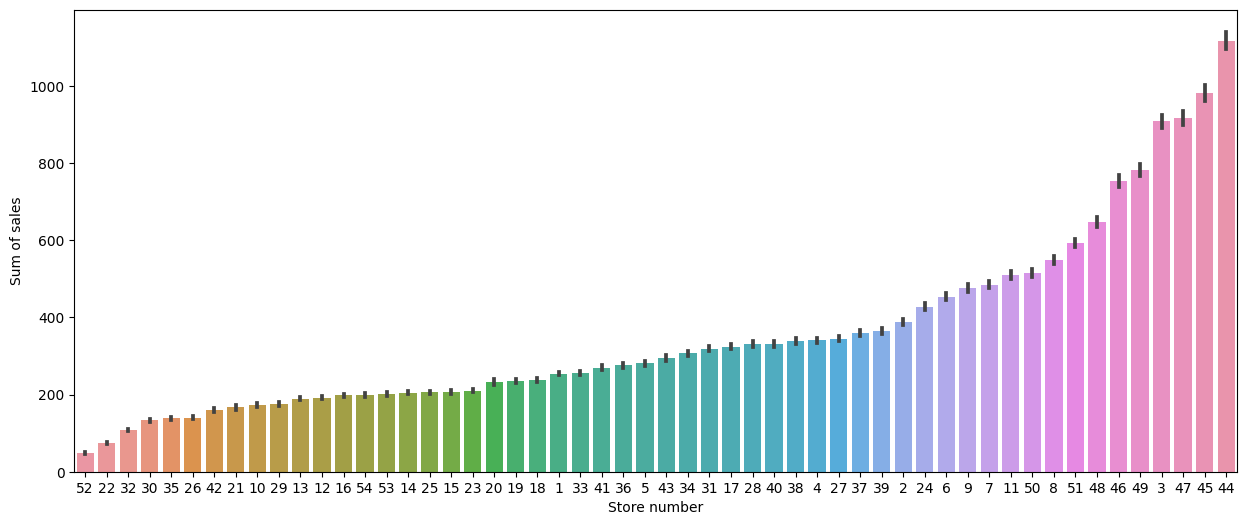

In [14]:
plt.figure(figsize=(15,6))
sns.barplot(data=train_df, x="store_nbr", y="sales", order=sorted_stores)
plt.xlabel("Store number")
plt.ylabel("Sum of sales")


In [15]:
correlation_with_prom = train_df["onpromotion"].corr(train_df["sales"])
correlation_with_prom

0.4279232048121313

In [16]:
correlation_with_oil = oil_df["dcoilwtico"].corr(train_df["sales"])
correlation_with_oil
#too low to use this feature in model

-0.049346765971872424

In [17]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
train_df = train_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)
test_df = test_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)

In [18]:
train_df.sample(10)

,id,date,store_nbr,family,sales,onpromotion
2511574,2511574,2016-11-13,3,EGGS,793.000,1
920536,920536,2014-06-02,38,BABY CARE,0.000,0
1980546,1980546,2016-01-20,3,HOME CARE,503.000,1
2695431,2695431,2017-02-25,38,MEATS,170.725,0
2819484,2819484,2017-05-06,19,PRODUCE,607.926,2
2475312,2475312,2016-10-24,12,HOME AND KITCHEN I,11.000,0
1312504,1312504,2015-01-09,35,POULTRY,44.442,0
173416,173416,2013-04-08,25,BABY CARE,0.000,0
1219671,1219671,2014-11-17,30,MEATS,42.943,0
1096926,1096926,2014-09-09,37,CELEBRATION,15.000,0


In [28]:
avg_sales_by_city= train_df.groupby("city")["sales"].mean().sort_values().reset_index()
avg_sales_by_city

,city,sales
0,Puyo,73.601845
1,Manta,125.173982
2,Playas,138.139340
3,Latacunga,190.583961
4,El Carmen,198.975799
5,Riobamba,204.921881
6,Salinas,205.517129
7,Ibarra,206.061866
8,Santo Domingo,214.942315
9,Guaranda,234.821670


Text(0, 0.5, 'Average sales')

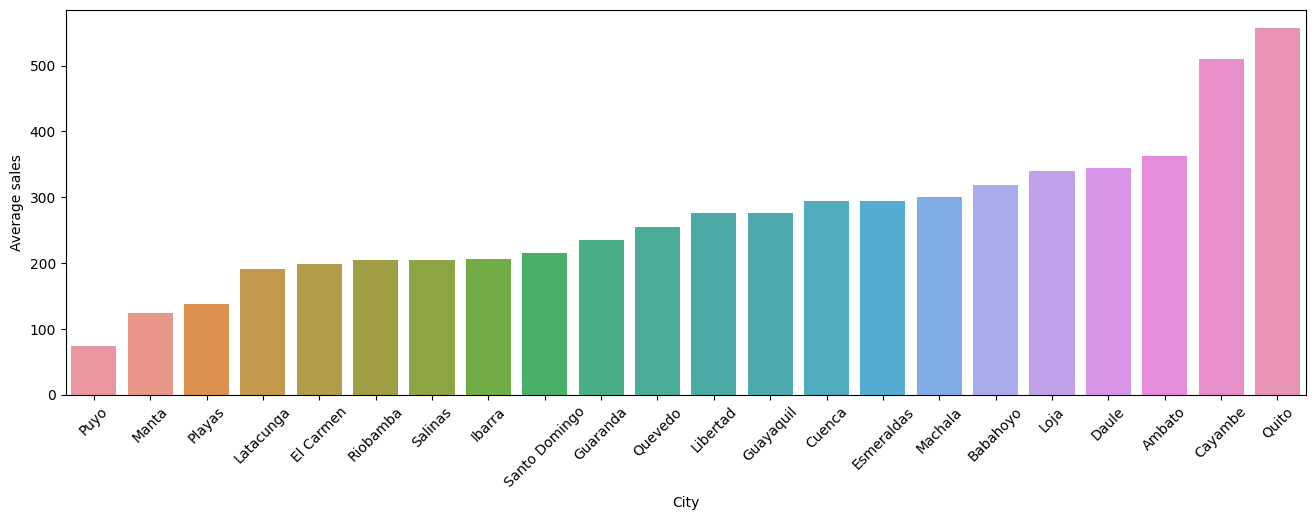

In [30]:
plt.figure(figsize=(16,5))
sns.barplot(x="city", y="sales", data=avg_sales_by_city)
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average sales")
#FIRST CATEGORY : <150  ["Puyo", "Manta", "Playas"]
#SECOND CATEGORY : 150 < 275 ["Latacunga", "El Carmen", "Riobamba", "Salinas", "Ibarra", "Santo Domingo", "Guaranda", "Quevedo"]
#THIRD CATEGORY 275 < 363 ["Libertad", "Guayaquil", "Cuenca", "Esmeraldas", "Machala", "Babahoyo", "Loja", "Daule", "Ambato"]
#FOURTH CATEGORY 363< ["Cayambe", "Quito"]

In [31]:
bins = [0, 150, 275, 363, 560]
labels =  [1, 2, 3, 4]
avg_sales_by_city["Category"]  = pd.cut(avg_sales_by_city["sales"], bins=bins, labels=labels)

In [32]:
city_to_category = avg_sales_by_city.set_index("city")["Category"].to_dict()
city_to_category

{'Puyo': 1,
 'Manta': 1,
 'Playas': 1,
 'Latacunga': 2,
 'El Carmen': 2,
 'Riobamba': 2,
 'Salinas': 2,
 'Ibarra': 2,
 'Santo Domingo': 2,
 'Guaranda': 2,
 'Quevedo': 2,
 'Libertad': 3,
 'Guayaquil': 3,
 'Cuenca': 3,
 'Esmeraldas': 3,
 'Machala': 3,
 'Babahoyo': 3,
 'Loja': 3,
 'Daule': 3,
 'Ambato': 3,
 'Cayambe': 4,
 'Quito': 4}

In [33]:
train_df["city_category"]  = train_df["city"].map(city_to_category)

In [34]:
train_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,city_category
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,4
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,4
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,4
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,4
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,4


<Axes: xlabel='family', ylabel='sales'>

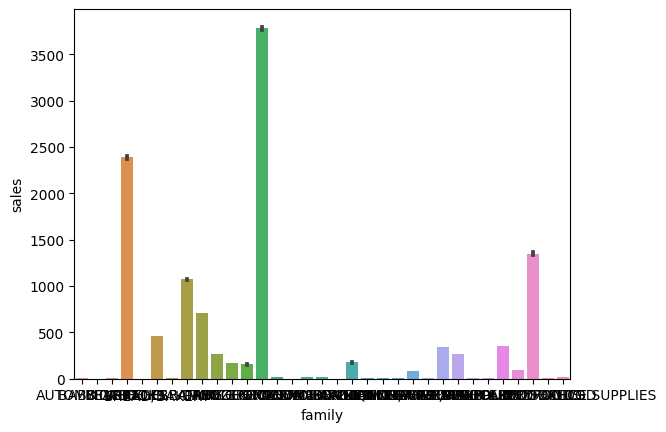

In [35]:
sns.barplot(data=train_df, x="family", y="sales")

In [36]:
avg_sales_by_family= train_df.groupby("family")["sales"].mean().sort_values().reset_index()
avg_sales_by_family

,family,sales
0,BOOKS,0.070797
1,BABY CARE,0.110528
2,HOME APPLIANCES,0.457476
3,HARDWARE,1.137833
4,MAGAZINES,2.929082
5,SCHOOL AND OFFICE SUPPLIES,2.961599
6,BEAUTY,3.715723
7,PET SUPPLIES,3.921263
8,LAWN AND GARDEN,6.035475
9,AUTOMOTIVE,6.101236
